In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
train_full_data = pd.read_csv('https://raw.githubusercontent.com/NHANGIOI/Machine_Learning/refs/heads/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/train.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/NHANGIOI/Machine_Learning/refs/heads/main/Titanic%20-%20Machine%20Learning%20from%20Disaster/test.csv')

x_train = train_full_data.copy().drop(columns = 'Survived')
y_train = train_full_data['Survived']

In [25]:
missing = x_train.isnull().mean().sort_values(ascending=False)
print(missing.head(10))


Cabin          0.771044
Age            0.198653
Embarked       0.002245
Name           0.000000
Pclass         0.000000
PassengerId    0.000000
Sex            0.000000
Parch          0.000000
SibSp          0.000000
Fare           0.000000
dtype: float64


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numerical_col = [col for col in x_train.columns if x_train[col].dtype in ['int','float']]
caterical_col = [col for col in x_train.columns if x_train[col].dtype == 'object']

pre_process = ColumnTransformer(transformers = [
    ('num_process',SimpleImputer(strategy = 'mean'),numerical_col),
    ('cat_1missing_process',Pipeline(steps = [
        ('missing',SimpleImputer(strategy = 'constant',fill_value = 'Missing')),
        ('encode',OneHotEncoder(handle_unknown = 'ignore'))
    ]),['Cabin']),
    ('cat_most_process',Pipeline(steps = [
        ('missing',SimpleImputer(strategy = 'most_frequent')),
        ('encode',OneHotEncoder(handle_unknown = 'ignore'))
    ]),[col for col in caterical_col if col != 'Cabin'])
])

In [32]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def run_model(n_estimators : int,output : bool):
    
    my_model = Pipeline(steps = [
        ('preprocess',pre_process),
        ('model', XGBClassifier(
        n_estimators = n_estimators,
        learning_rate = 0.05,
        eval_metric = 'logloss',
        n_jobs = 4
        ))
    ])
    my_model.fit(x_train,y_train)
    
    if output == False:
        scores = -1 * cross_val_score(my_model,x_train,y_train,
                                      cv = 5, scoring = 'neg_mean_absolute_error')
        return scores.mean()
    else:
        return my_model.predict(x_test)

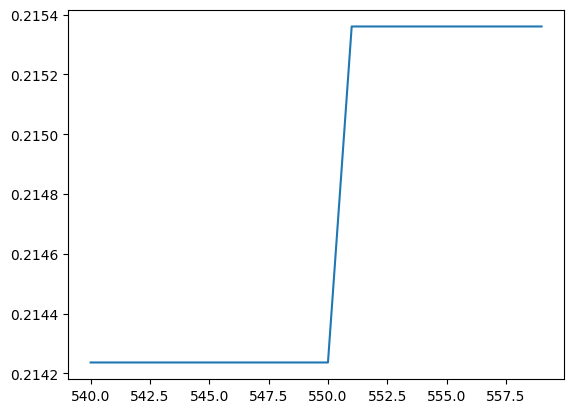

In [35]:
import matplotlib.pyplot as plt
list_mae = {}
for i in range(540,560,1):
    list_mae[i] = run_model(i,False)
%matplotlib inline
plt.plot(list(list_mae.keys()),list(list_mae.values()))
plt.show()

In [ ]:
submission = pd.DataFrame({
    'PassengerId' : x_test['PassengerId'],
    'Survived' : run_model(545,True)
})
submission.to_csv('/kaggle/working/submission.csv',index = False)